In [66]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [32]:
def import_json(path):
    """Import data in json format.
    - parameters: 
        path => path of .json file
    - return: dictionary from .json file
    """
    with open(path) as data_file:    
        return json.load(data_file)

In [33]:
data_dict = import_json('data/all.json')

In [34]:
def convert_dict_to_data_frame(dict, show_info=False):
    """Convert dictionary to data frame object.
    - parameters: 
        dict => dictionary
        show_info => variable for indicating show or hide data frame info (default=False)
    - return: data frame object from dictionary
    """
    df = pd.DataFrame.from_dict(dict, orient='columns')
    if show_info:
        df.info()
    return df

In [43]:
df = convert_dict_to_data_frame(data_dict)

In [40]:
def prepare_category_id(data_frame, column):
    """Create new column 'category_id'
    parameters:
        data_frame => data frame object
        column => column name that you want use as an input
        return: new data frame object that include 'category_id' column
    """
    data_frame['category_id'] = data_frame[column].factorize()[0]
    return data_frame

In [45]:
df = prepare_category_id(df, 'label')

In [47]:
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(category_to_id)

{'Bug': 0, 'Rating': 1, 'Feature': 2, 'UserExperience': 3}


In [50]:
id_to_category = dict(category_id_df[['category_id', 'label']].values)
print(id_to_category)

{0: 'Bug', 1: 'Rating', 2: 'Feature', 3: 'UserExperience'}


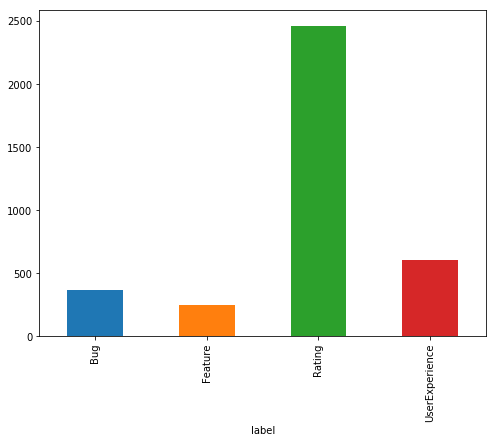

In [53]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').comment.count().plot.bar(ylim=0)
plt.show()

In [54]:
print(pd.value_counts(pd.Series(df['label'])))

Rating            2462
UserExperience     607
Bug                370
Feature            252
Name: label, dtype: int64


In [56]:
tfidf = TfidfVectorizer(sublinear_tf=True, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [59]:
features = tfidf.fit_transform(df.comment)
labels = df.category_id
print(features.shape)
print(labels.shape)

(3691, 27402)
(3691,)


In [62]:
N = 2
for label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bug':
  . Most correlated unigrams:
. open
. fix
  . Most correlated bigrams:
. crashes time
. won open
# 'Feature':
  . Most correlated unigrams:
. increase
. nexus
  . Most correlated bigrams:
. fix download
. black screen
# 'Rating':
  . Most correlated unigrams:
. fix
. good
  . Most correlated bigrams:
. new update
. good good
# 'UserExperience':
  . Most correlated unigrams:
. easy
. reviews
  . Most correlated bigrams:
. love ability
. easy use


In [64]:
def smote_data(features, labels, show_info=False):
    """Oversampling minor class by SMOTE technique.
    parameters:
        features => Any features that can be used to train model.
        labels => target variable e.g. 0, 1, 2, 3, ...
        show_info => Show resampled data if you want (default=False)
    return: tuple of resampled features and resampled labels
    """
    method = SMOTE(kind='regular')
    X_resampled, y_resampled = method.fit_sample(features, labels)
    
    if show_info:
        print(pd.value_counts(pd.Series(y_resampled)))
    
    return X_resampled, y_resampled

In [65]:
X_resampled, y_resampled = smote_data(features, labels, show_info=True)

3    2462
2    2462
1    2462
0    2462
dtype: int64
